# NVIDIA Stock Price Prediction using LSTM

This notebook demonstrates how to use LSTM (Long Short-Term Memory) networks to predict NVIDIA stock prices using PyTorch.

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

## Load and Prepare Data

In [2]:
# Load data
df = pd.read_csv('NVDA.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Use closing price for prediction
data = df['Close'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(data_scaled, seq_length)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

## Define LSTM Model

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        predictions = self.linear(lstm_out[:, -1, :])
        return predictions

## Train the Model

In [4]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0001
Epoch [20/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0001
Epoch [40/100], Loss: 0.0001
Epoch [50/100], Loss: 0.0001
Epoch [60/100], Loss: 0.0001
Epoch [70/100], Loss: 0.0001
Epoch [80/100], Loss: 0.0001
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0000


## Evaluate Model Performance

In [5]:
model.eval()
with torch.no_grad():
    train_predictions = model(X_train)
    test_predictions = model(X_test)
    
# Convert predictions back to original scale
train_predictions = scaler.inverse_transform(train_predictions.numpy())
test_predictions = scaler.inverse_transform(test_predictions.numpy())
y_train_orig = scaler.inverse_transform(y_train.numpy())
y_test_orig = scaler.inverse_transform(y_test.numpy())

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_orig, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_predictions))
train_r2 = r2_score(y_train_orig, train_predictions)
test_r2 = r2_score(y_test_orig, test_predictions)

print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Train R2 Score: {train_r2:.4f}')
print(f'Test R2 Score: {test_r2:.4f}')

Train RMSE: 0.9995
Test RMSE: 36.4305
Train R2 Score: 0.5851
Test R2 Score: 0.1907


## Plot Results

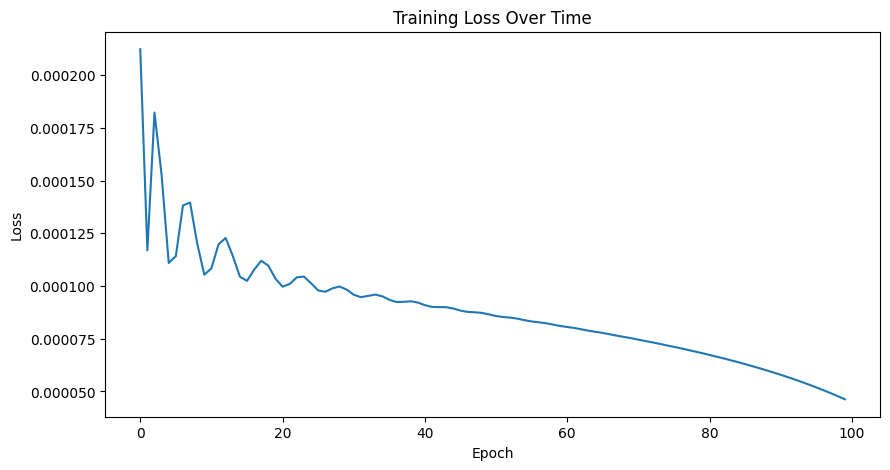

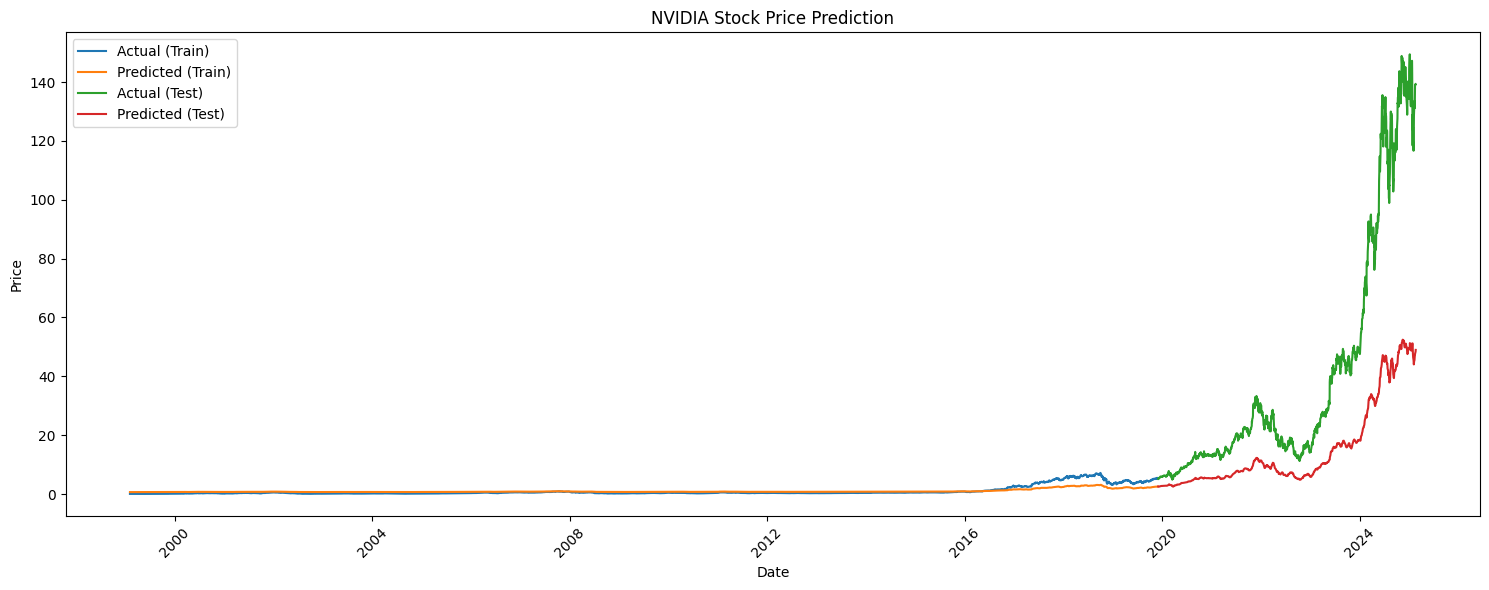

In [6]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(df.index[seq_length:train_size+seq_length], y_train_orig, label='Actual (Train)')
plt.plot(df.index[seq_length:train_size+seq_length], train_predictions, label='Predicted (Train)')
plt.plot(df.index[train_size+seq_length:], y_test_orig, label='Actual (Test)')
plt.plot(df.index[train_size+seq_length:], test_predictions, label='Predicted (Test)')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()